In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

import core.utils as utils
import core.wcrg as wcrg
import core.macro as macro

In [65]:
x = np.load('data/weak_lensing.npy')
x = utils.preprocessing_weak_lensing(x)
x = torch.tensor(x)

In [67]:
s = x
d = s + torch.randn(*s.shape)
torch.save((s, d), 'data/weak_lensing.pt')

In [68]:
s, d = torch.load('data/weak_lensing.pt')
s, d = s.cuda(), d.cuda()

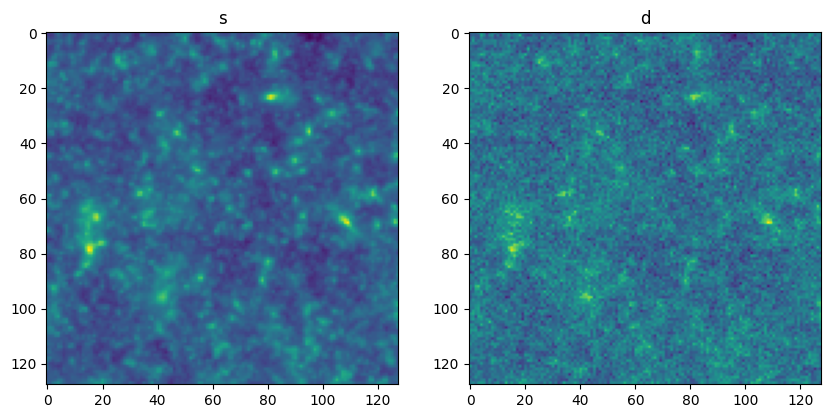

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
ax1.imshow(s[0].cpu())
ax2.imshow(d[0].cpu())
ax1.set_title("s")
ax2.set_title("d")
plt.show()

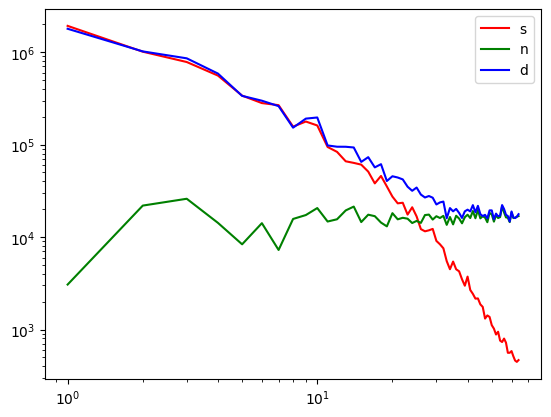

In [23]:
for x, name, c in zip([s[0], d[0] - s[0], d[0]], ["s", "n", "d"], ["r", "g", "b"]):
    k, bins = utils.power_spectrum(x.cpu())
    plt.loglog(k, bins, label=name, c=c)
    
plt.legend()
plt.show()

In [3]:
m = 4
W = wcrg.Db_wavelets(m, device='cuda', mode='Periodic')

In [76]:
J = int(np.log2(d.shape[-1]))
L = 16

depth = J - int(np.log2(L))
phi_s = wcrg.load_data(W, s[:1000], depth, J, show_hist=False)
phi_d = wcrg.load_data(W, d[:1000], depth, J, show_hist=False)

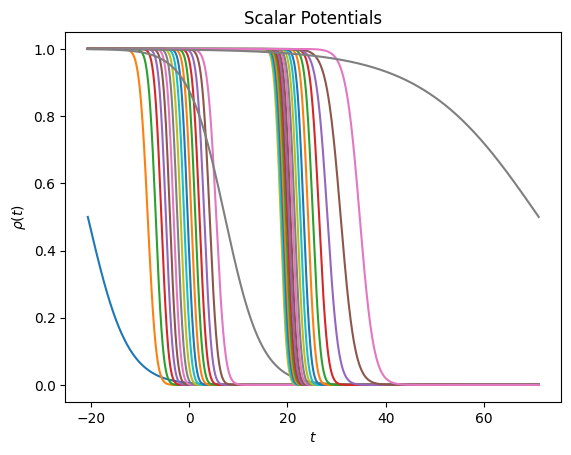

In [77]:
num_potentials_1 = 20
num_potentials_2 = 20

shifts = ((0,1),(1,0),(1,1),(-1,1),
          (0,2),(2,0),(2,2),(-2,2),
          (2,1),(1,2),(-1,2),(2,-1))

centers_1 = torch.quantile(phi_d, torch.linspace(0, 0.99, num_potentials_1).cuda())[:-1]
centers_2 = torch.quantile(phi_d, torch.linspace(0.99, 1, num_potentials_2).cuda())
centers = torch.cat([centers_1[:-1], centers_2])

sigma = 0.5 * 0.65 * torch.cat([centers[1:-1] - centers[:-2],
                                (centers[-2] - centers[-3])[None],
                                (centers[-1] - centers[-2])[None]])

macro.Plot_NoiseSigmoid(centers, sigma)

mode = 'All'
ansatz = macro.NoiseANSATZ_Wavelet(W, L, centers, sigma, mode, shifts)
clean_ansatz = wcrg.ANSATZ_Wavelet(W, L, centers, sigma, mode, shifts)

In [7]:
noise_pixel_ansatz = macro.NoisePixelEnergy(ansatz.ansatze[0].centers, ansatz.ansatze[0].sigma)
phi, loss_list = macro.denoise_pixel(ansatz, noise_pixel_ansatz, phi_d, lr=1e-1, n_epochs=25, step=5)

Iteration 0
Acceptance rate 1.0
Acceptance rate 1.0
Acceptance rate 1.0
Acceptance rate 1.0
Acceptance rate 1.0
Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', requires_grad=True)
tensor([-7.2007e-01, -1.7060e+00, -1.2104e+00, -8.5585e-01, -5.4185e-01,
        -2.5335e-01, -1.4294e-01, -2.9671e-01, -2.8136e-01, -4.8883e-02,
         1.2910e-01,  2.7018e-01,  4.1714e-01,  4.9423e-01,  6.3977e-01,
         9.0146e-01,  1.1879e+00,  1.3329e+00,  2.1243e-01,  1.3549e-01,
         5.4263e-02,  2.9854e-02,  5.6228e-03,  1.0096e-03,  6.0721e-04,
        -2.1031e-03, -1.4924e-02, -1.6617e-02, -1.9539e-02, -1.2605e-02,
        -7.5380e-03, -1.0087e-02, -1.5425e-02, -1.9338e-02, -2.4807e-02,
        -5.6255e-02, -1.6063e-01, -3.2249e-01, -2.9962e-04], device='cuda:0')
Loss 17.83005714416504
Iteration 1
Acceptance rate 0.9689428

Acceptance rate 0.5995181274414062
Acceptance rate 0.5979067993164062
Acceptance rate 0.5963214111328125
Acceptance rate 0.5971755981445312
Acceptance rate 0.5966009521484374
Parameter containing:
tensor([ 1.5968e+00,  2.5512e+00,  9.6248e-01,  4.1908e-01,  1.9283e-01,
        -8.9931e-02, -1.3701e-01,  3.3411e-01,  4.0130e-01,  1.9125e-02,
        -1.5188e-01, -1.7259e-01, -2.0288e-01, -6.1038e-02, -6.4153e-02,
        -4.5169e-01, -1.1279e+00, -2.2793e+00, -5.2453e-01, -3.5855e-01,
        -1.8089e-01, -1.2705e-01, -7.1991e-02, -5.9839e-02, -5.5648e-02,
        -4.2856e-02, -7.5343e-04,  1.2118e-02,  2.8782e-02,  1.5801e-02,
         7.0401e-03,  1.5541e-02,  3.3727e-02,  5.3583e-02,  8.3317e-02,
         1.9413e-01,  4.1149e-01,  6.2119e-01,  9.9596e-04], device='cuda:0',
       requires_grad=True)
tensor([-0.3467,  0.5219,  0.9358,  0.5172,  0.1133,  0.0344,  0.0843, -0.0292,
        -0.0395,  0.0575,  0.0328, -0.0232, -0.0142, -0.1006, -0.3074, -0.6349,
        -1.0543, -0.1766,  

Acceptance rate 0.7443206787109375
Acceptance rate 0.7440240478515625
Parameter containing:
tensor([ 3.4419e+00,  2.8917e+00, -5.1864e-01, -3.4547e-01,  1.6684e-01,
        -2.2185e-01, -4.7417e-01,  5.7799e-01,  7.2048e-01, -1.3075e-01,
        -3.0286e-01, -1.3137e-01, -1.7073e-01,  2.1005e-01,  5.0113e-01,
         3.7205e-01,  1.2735e-01, -3.4200e+00, -7.9846e-01, -4.8025e-01,
        -1.4342e-01, -6.7948e-02, -4.9925e-04, -2.4839e-02, -5.4790e-02,
        -6.0223e-02,  3.0324e-03,  2.3055e-02,  5.4140e-02,  1.0162e-02,
        -2.8769e-02, -1.8624e-02,  1.0240e-02,  3.8617e-02,  1.1188e-01,
         3.7268e-01,  7.7631e-01,  1.1213e+00,  3.5103e-03], device='cuda:0',
       requires_grad=True)
tensor([-0.1798,  0.2440,  0.1144, -0.2566, -0.3366, -0.1175,  0.0972,  0.0414,
         0.0152,  0.0589, -0.0261, -0.1030, -0.0140,  0.1279,  0.2958,  0.3257,
        -0.0492, -0.1613, -0.1664, -0.1655, -0.1627, -0.1473, -0.1258, -0.0990,
        -0.0769, -0.0574, -0.0412, -0.0336, -0.0268,

Acceptance rate 0.7666928100585938
Acceptance rate 0.7664678955078125
Acceptance rate 0.7662490844726563
Acceptance rate 0.76667724609375
Acceptance rate 0.7662374877929687
Parameter containing:
tensor([ 4.8909e+00,  2.2569e+00, -1.7353e+00, -1.2363e-01,  1.0146e+00,
        -2.0471e-02, -9.5117e-01,  5.9615e-01,  8.6350e-01, -3.7390e-01,
        -3.3389e-01,  1.4935e-01, -1.0239e-01,  8.0717e-02,  1.0692e-01,
         4.1040e-02,  1.0870e+00, -3.5850e+00, -5.5812e-01, -1.6704e-01,
         2.4116e-01,  2.8378e-01,  2.9789e-01,  1.8112e-01,  7.4861e-02,
         1.3140e-02,  5.8359e-02,  7.4028e-02,  1.1345e-01,  3.0876e-02,
        -4.7360e-02, -4.3909e-02, -2.2890e-02, -2.0379e-02,  6.1404e-02,
         3.9255e-01,  8.7653e-01,  1.3719e+00,  3.9188e-03], device='cuda:0',
       requires_grad=True)
tensor([-1.2778e-01, -1.2127e-01, -2.8861e-01, -3.2981e-01, -1.5800e-01,
         9.1392e-02,  2.0036e-01,  3.2498e-02, -3.1809e-02,  3.5504e-02,
        -1.7099e-02, -1.0056e-01, -7.5599e-

In [9]:
noise_pixel_ansatz.theta.data = loss_list[np.argmin([x[0] for x in loss_list])][1]
phi, loss_list = macro.denoise_pixel(ansatz, noise_pixel_ansatz, phi_d, lr=1e-2, momentum=0, n_epochs=25, step=5)

Iteration 0
Acceptance rate 0.6567788696289063
Acceptance rate 0.6557760620117188
Acceptance rate 0.6555099487304688
Acceptance rate 0.6554364013671875
Acceptance rate 0.65568115234375
Parameter containing:
tensor([ 2.5751e+00,  3.0537e+00,  4.1357e-01,  3.7396e-02,  1.0530e-01,
        -2.0035e-01, -2.9255e-01,  4.8359e-01,  5.8844e-01, -3.4667e-02,
        -2.3880e-01, -1.8821e-01, -2.0466e-01,  9.8570e-02,  2.8249e-01,
        -7.1914e-03, -6.4561e-01, -3.0536e+00, -7.7009e-01, -5.1626e-01,
        -2.4517e-01, -1.7113e-01, -9.8035e-02, -9.3638e-02, -9.8181e-02,
        -8.6230e-02, -2.3777e-02, -3.2831e-03,  2.4591e-02, -3.9763e-04,
        -1.9339e-02, -6.0251e-03,  2.4660e-02,  5.9117e-02,  1.1776e-01,
         3.1970e-01,  6.4826e-01,  9.1460e-01,  2.5914e-03], device='cuda:0',
       requires_grad=True)
tensor([-1.7070e-01,  7.3923e-01,  6.8416e-01,  1.0936e-01, -1.6457e-01,
        -5.1809e-02,  1.1177e-01,  2.3901e-02, -9.4340e-03,  5.5118e-02,
        -2.4753e-03, -7.5924e-0

Acceptance rate 0.6589718627929687
Acceptance rate 0.6589401245117188
Acceptance rate 0.658865966796875
Acceptance rate 0.6590676879882813
Acceptance rate 0.6587344360351562
Parameter containing:
tensor([ 2.5856e+00,  3.0107e+00,  3.7296e-01,  3.0283e-02,  1.1491e-01,
        -1.9653e-01, -2.9840e-01,  4.8207e-01,  5.8811e-01, -3.8763e-02,
        -2.3879e-01, -1.8303e-01, -2.0176e-01,  9.8335e-02,  2.7949e-01,
        -3.7494e-03, -6.1425e-01, -3.0377e+00, -7.5749e-01, -5.0365e-01,
        -2.3272e-01, -1.5963e-01, -8.7867e-02, -8.5137e-02, -9.1073e-02,
        -8.0419e-02, -1.9235e-02,  4.4614e-04,  2.7315e-02,  1.0693e-03,
        -1.9553e-02, -7.2463e-03,  2.2273e-02,  5.5527e-02,  1.1390e-01,
         3.1566e-01,  6.4407e-01,  9.1382e-01,  2.5880e-03], device='cuda:0',
       requires_grad=True)
tensor([-1.9854e-01,  6.3400e-01,  6.2961e-01,  1.2148e-01, -1.4673e-01,
        -7.1483e-02,  7.7074e-02,  1.3565e-02,  9.1561e-03,  7.7300e-02,
         4.3130e-03, -8.9089e-02, -5.5950e

Acceptance rate 0.661324462890625
Acceptance rate 0.6615377807617188
Acceptance rate 0.6618148803710937
Acceptance rate 0.6624777221679687
Acceptance rate 0.6616506958007813
Parameter containing:
tensor([ 2.5965e+00,  2.9710e+00,  3.3491e-01,  2.3772e-02,  1.2403e-01,
        -1.9310e-01, -3.0416e-01,  4.8084e-01,  5.8788e-01, -4.2996e-02,
        -2.3897e-01, -1.7790e-01, -1.9866e-01,  9.8553e-02,  2.7653e-01,
        -1.6256e-03, -5.8511e-01, -3.0220e+00, -7.4527e-01, -4.9149e-01,
        -2.2075e-01, -1.4860e-01, -7.8141e-02, -7.7016e-02, -8.4269e-02,
        -7.4772e-02, -1.4594e-02,  4.4749e-03,  3.0610e-02,  3.2675e-03,
        -1.8851e-02, -7.5315e-03,  2.0716e-02,  5.2484e-02,  1.1028e-01,
         3.1145e-01,  6.3962e-01,  9.1311e-01,  2.5954e-03], device='cuda:0',
       requires_grad=True)
tensor([-1.8763e-01,  6.3286e-01,  6.1655e-01,  9.7713e-02, -1.5201e-01,
        -4.9875e-02,  1.0298e-01,  2.2283e-02,  3.4071e-04,  6.6237e-02,
         3.0225e-03, -7.8140e-02, -3.7717e

Acceptance rate 0.6646905517578126
Acceptance rate 0.6647528076171875
Acceptance rate 0.664442138671875
Acceptance rate 0.6644894409179688
Acceptance rate 0.6648013305664062
Parameter containing:
tensor([ 2.6077e+00,  2.9346e+00,  2.9923e-01,  1.7972e-02,  1.3296e-01,
        -1.8996e-01, -3.0992e-01,  4.7989e-01,  5.8800e-01, -4.7026e-02,
        -2.3924e-01, -1.7312e-01, -1.9594e-01,  9.8448e-02,  2.7323e-01,
         1.0516e-04, -5.5611e-01, -3.0066e+00, -7.3446e-01, -4.8059e-01,
        -2.0994e-01, -1.3870e-01, -6.9549e-02, -7.0074e-02, -7.8708e-02,
        -7.0483e-02, -1.1488e-02,  6.9458e-03,  3.2480e-02,  4.3023e-03,
        -1.8884e-02, -8.2422e-03,  1.9159e-02,  5.0003e-02,  1.0751e-01,
         3.0836e-01,  6.3617e-01,  9.1253e-01,  2.6096e-03], device='cuda:0',
       requires_grad=True)
tensor([-1.7609e-01,  6.0102e-01,  5.6808e-01,  8.2611e-02, -1.4908e-01,
        -4.4580e-02,  1.0057e-01,  1.0409e-02, -9.4183e-03,  6.7769e-02,
         1.2867e-02, -7.1596e-02, -4.5193e

Acceptance rate 0.6674371337890626
Acceptance rate 0.66721923828125
Acceptance rate 0.6674615478515625
Acceptance rate 0.6674639892578125
Acceptance rate 0.6676861572265625
Parameter containing:
tensor([ 2.6188e+00,  2.8996e+00,  2.6493e-01,  1.3203e-02,  1.4239e-01,
        -1.8700e-01, -3.1628e-01,  4.7851e-01,  5.8817e-01, -5.0764e-02,
        -2.3926e-01, -1.6823e-01, -1.9316e-01,  9.8292e-02,  2.6955e-01,
         1.0188e-03, -5.2860e-01, -2.9914e+00, -7.2368e-01, -4.6989e-01,
        -1.9947e-01, -1.2920e-01, -6.1360e-02, -6.3511e-02, -7.3476e-02,
        -6.6411e-02, -8.3758e-03,  9.5838e-03,  3.4669e-02,  5.6068e-03,
        -1.8826e-02, -9.0344e-03,  1.7368e-02,  4.7242e-02,  1.0448e-01,
         3.0498e-01,  6.3242e-01,  9.1196e-01,  2.6249e-03], device='cuda:0',
       requires_grad=True)
tensor([-1.8393e-01,  6.0004e-01,  5.6271e-01,  7.4172e-02, -1.5357e-01,
        -4.7593e-02,  9.6523e-02,  8.7922e-03, -6.9558e-03,  7.1442e-02,
         1.6916e-02, -6.7936e-02, -4.9181e-

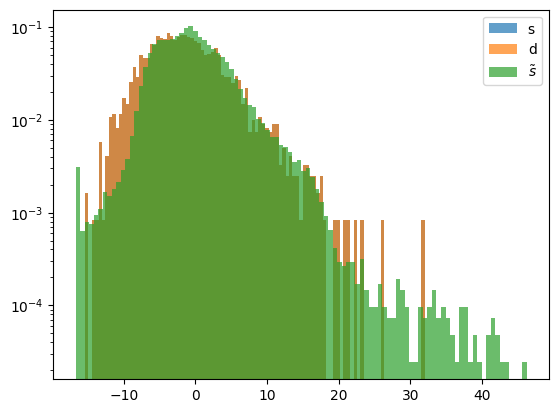

In [15]:
plt.hist(phi_s[:10].ravel().cpu(), bins=100, density=True, alpha=0.7, label="s")
plt.hist(phi_d[:10].ravel().cpu(), bins=100, density=True, alpha=0.7, label="d")
plt.hist(phi.cpu(), bins=100, density=True, alpha=0.7, label=r"$\tilde{s}$")
plt.yscale('log')
plt.legend()
plt.show()

In [91]:
ansatz.ansatze[0].sigma

tensor([ 3.9610,  0.5290,  0.3711,  0.3020,  0.2675,  0.2461,  0.2361,  0.2274,
         0.2274,  0.2334,  0.2454,  0.2610,  0.2763,  0.3138,  0.3581,  0.4334,
         0.5758,  3.6777,  0.0764,  0.0857,  0.0861,  0.1027,  0.0969,  0.1010,
         0.1189,  0.1300,  0.1392,  0.1772,  0.1951,  0.2237,  0.2851,  0.3195,
         0.4098,  0.5488,  0.8795,  1.2587,  1.2587, 11.8331], device='cuda:0')

In [92]:
sigma

tensor([ 3.9610,  0.5290,  0.3711,  0.3020,  0.2675,  0.2461,  0.2361,  0.2274,
         0.2274,  0.2334,  0.2454,  0.2610,  0.2763,  0.3138,  0.3581,  0.4334,
         0.5758,  3.6777,  0.0764,  0.0857,  0.0861,  0.1027,  0.0969,  0.1010,
         0.1189,  0.1300,  0.1392,  0.1772,  0.1951,  0.2237,  0.2851,  0.3195,
         0.4098,  0.5488,  0.8795,  1.2587,  1.2587, 11.8331], device='cuda:0')

In [71]:
#DELETE
phi = phi_s[:100].ravel()

In [78]:
dataloader = torch.utils.data.DataLoader(phi_d, batch_size=100)
shift = macro.calculate_shift(clean_ansatz, ansatz, phi[::12])
ansatz.rescale_theta = macro.calculate_rescale(clean_ansatz, dataloader, shift, mean_mode=False)

In [79]:
theta = ansatz.theta()
grad_mean, laplace_mean = clean_ansatz.compute_grad(phi_d, None)

In [80]:
evals, evecs = torch.linalg.eigh(grad_mean - shift)
pos_evals = torch.clamp(evals, min=0)
pos_grad = evecs @ torch.diag(pos_evals) @ evecs.T

In [82]:
noise_grad_mean, noise_laplace_mean = ansatz.compute_grad(phi_s[:500], None)

In [83]:
torch.mean((noise_laplace_mean - laplace_mean)**2)

tensor(0.0022, device='cuda:0')

In [84]:
torch.mean((grad_mean - shift - noise_grad_mean)**2)

tensor(9.1151, device='cuda:0')

In [87]:
torch.mean((pos_grad - noise_grad_mean)**2)

tensor(9.1279, device='cuda:0')

In [86]:
torch.mean((noise_grad_mean - grad_mean)**2)

tensor(10.9913, device='cuda:0')

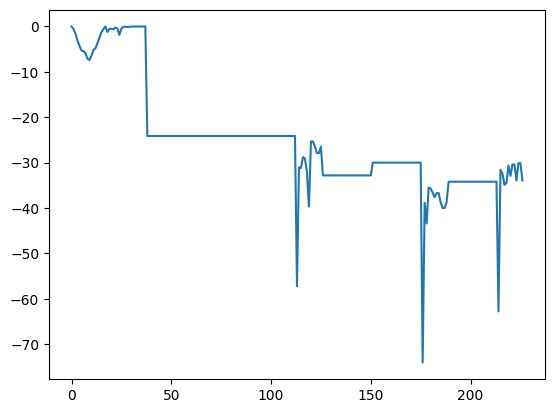

In [64]:
plt.plot((noise_grad_mean - grad_mean).diag().cpu())
plt.show()

In [53]:
lr = 1e-2
momentum = 0
num_epochs = 10

optimizer = torch.optim.SGD([ansatz.theta_no_rescale], lr=lr, momentum=momentum)

for q in range(num_epochs):    
    for x in dataloader:
        theta = ansatz.theta()
        grad_mean, laplace_mean = clean_ansatz.compute_grad(x, None)
        
        evals, evecs = torch.linalg.eigh(grad_mean - shift)
        pos_evals = torch.clamp(evals, min=0)
        pos_grad = evecs @ torch.diag(pos_evals) @ evecs.T

        quad = torch.sum(pos_grad * theta[:, None] * theta[None, :])
        linear = torch.sum(laplace_mean * theta)
        loss = quad - 2 * linear

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        print( '[{}/{}] loss: {:.8}'.format(q, num_epochs, loss.item()))

[0/10] loss: 0.0
[0/10] loss: -2.6542497
[0/10] loss: -4.3721576
[0/10] loss: -4.6631613
[0/10] loss: -9.8415098
[0/10] loss: 2.1958554
[0/10] loss: -1.1366117
[0/10] loss: -11.651394
[0/10] loss: -7.6544375
[0/10] loss: -8.5244598
[0/10] loss: -8.5042782
[0/10] loss: 0.96959066
[0/10] loss: 9.4213924
[0/10] loss: -14.951069
[0/10] loss: 5.6265383
[0/10] loss: -11.02318
[1/10] loss: -4.5387921
[1/10] loss: -16.085785
[1/10] loss: -21.1875
[1/10] loss: -24.09948
[1/10] loss: 10.763357
[1/10] loss: -14.624675
[1/10] loss: -6.237772
[1/10] loss: -18.838057
[1/10] loss: -8.8048038
[1/10] loss: -8.1508055
[1/10] loss: -20.434433
[1/10] loss: -23.020061
[1/10] loss: -24.967854
[1/10] loss: -33.525272
[1/10] loss: -16.483677
[1/10] loss: -11.201216
[2/10] loss: -15.012891
[2/10] loss: -15.579514
[2/10] loss: -14.871655
[2/10] loss: -18.644457
[2/10] loss: -39.282639
[2/10] loss: -22.900208
[2/10] loss: -2.3082352
[2/10] loss: -11.366792
[2/10] loss: -14.672084
[2/10] loss: -12.370548
[2/10] l